In [1]:
import os
import torch
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from tqdm import tqdm

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: 

In [2]:
adata = sc.read('./feature/batch.h5ad')

In [3]:
import harmonypy as hm

meta_data = adata.obs[['batch']]

data_mat = adata.obsm['STAGATE']
vars_use = ['batch']
ho = hm.run_harmony(data_mat, meta_data, vars_use)

res = pd.DataFrame(ho.Z_corr).T
res_df = pd.DataFrame(data=res.values, columns=['X{}'.format(i+1) for i in range(res.shape[1])], index=adata.obs.index)
adata.obsm[f'SEDR.Harmony'] = res_df

2025-04-07 21:34:56,438 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-07 21:34:59,804 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-07 21:34:59,886 - harmonypy - INFO - Iteration 1 of 10
2025-04-07 21:35:01,048 - harmonypy - INFO - Iteration 2 of 10
2025-04-07 21:35:01,497 - harmonypy - INFO - Converged after 2 iterations


In [4]:
sc.pp.neighbors(adata, use_rep='SEDR.Harmony', metric='cosine')
sc.tl.umap(adata, min_dist=0.2)

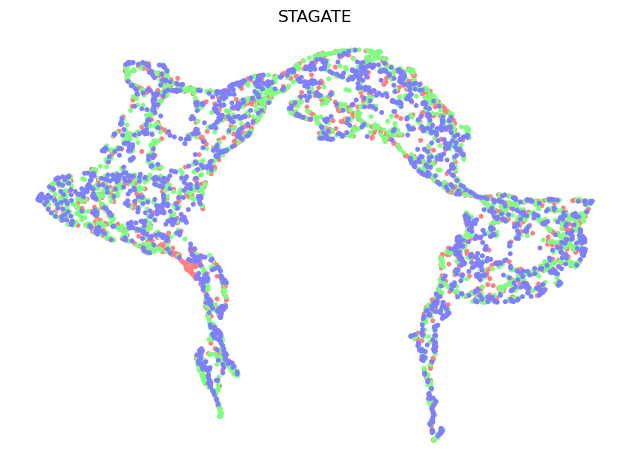

In [9]:
sc.pl.umap(
    adata, 
    color=['batch_name'], 
    palette=['#FF7F7F', '#7FFF7F', '#7F7FFF'], 
    show=False, 
    size=50, 
    frameon=False,  # 去掉外边框
    legend_loc='left margin',  # 调整图例位置
    title="STAGATE" 
)

# 获取当前图形并修改散点样式
ax = plt.gca()
for path in ax.spines.values():  
    path.set_visible(True)  # 显示边框
    path.set_linewidth(0)   # 设置边框粗细

# 手动调整点的边框颜色
scatter = ax.collections[0]  # 获取散点图
scatter.set_edgecolor('white')  # 设置边框颜色
scatter.set_linewidth(0)  # 设置边框宽度
plt.tight_layout()
plt.savefig('umap_batch.svg', format='svg')
plt.show()

In [6]:
ILISI = hm.compute_lisi(adata.obsm['SEDR.Harmony'], adata.obs[['batch']], label_colnames=['batch'])[:, 0]
CLISI = hm.compute_lisi(adata.obsm['SEDR.Harmony'], adata.obs[['Region']], label_colnames=['Region'])[:, 0]

In [7]:
mean_ILISI = np.mean(np.array(ILISI))
mean_CLISI = np.mean(np.array(CLISI))
print("mean_ILISI:", mean_ILISI)
print("mean_CLISI:", mean_CLISI)

mean_ILISI: 1.6181482726044778
mean_CLISI: 1.1247466647883009


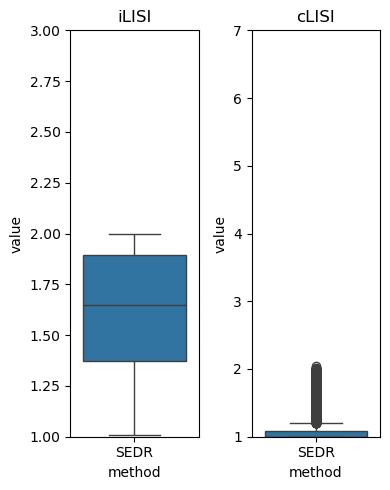

In [8]:
df_ILISI = pd.DataFrame({
    'method': 'SEDR',
    'value': ILISI,
    'type': ['ILISI']*len(ILISI)
})


df_CLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': CLISI,
    'type': ['CLISI']*len(CLISI)
})

fig, axes = plt.subplots(1,2,figsize=(4, 5))
sns.boxplot(data=df_ILISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_CLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()